In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
import time
import warnings
import matplotlib.pyplot as plt

In [2]:
from autoimpute.imputations import MiceImputer,SingleImputer

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
from statsmodels.imputation.mice import MICE
from statsmodels.imputation.mice import MICEData
import statsmodels.api as sm

In [5]:
# Set some debugging parameters
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [6]:
TRAINING_PERIOD = 4
LAG_PREDICTORS = True
NLAG = 1
DEPVAR = "asylum seekers" 
# "asylum seekers" | "asylum seekers (global stock)" | "refugees (global stock)"
LOG_TRANSFORM_DEPVAR = True
PER_CAPITA_TRANSFORM_DEPVAR = True
SPEI_MOVING_AVERAGES_3_6 = False
NSTEP_AHEAD = 1
CALCULATE_INTERACTIONS = False

In [7]:
# Read Dataset directly from file and pre-process
# original_dataset = pd.read_csv("../Data/replication_data.csv")
original_dataset = pd.read_csv("../../Data/USAAsylumApplications&UnauthorizedMigration/USA_cleaned_asylum_2007_2018.csv")
original_dataset['n_asylum'] = original_dataset['n_asylum'].fillna(0)
original_dataset['n_asylum_eu28'] = original_dataset['n_asylum_eu28'].fillna(0)
original_dataset['n_asylum_eu28'] = original_dataset['US_asylum_applications'].fillna(0)
original_dataset['n_refugees'] = original_dataset['n_refugees'].fillna(0)
original_dataset['spei3_gs_neg'] = original_dataset['spei3_gs_neg'].apply(lambda x: x*12)
original_dataset['spei3_gs_pos'] = original_dataset['spei3_gs_pos'].apply(lambda x: x*12)
original_dataset['physical_integrity'] = original_dataset['civil_liberties_combined']

In [8]:
# Remove all microstates from the list
microstates = pd.read_csv("../Data/microstates.dat", sep = "\t", names=['gwcode','iso3','name','d1','d2'])
microstates_list = microstates['gwcode'].to_list()
dataset = original_dataset[~original_dataset['gwcode'].isin(microstates_list)]
# dataset = original_dataset

In [9]:
# Original code did log(population+1),  I have directly did log population and inf values are 0
# EU
# if DEPVAR == "asylum seekers":
#     dataset['orig_depvar'] = dataset['n_asylum_eu28']
#     dataset['ln_depvar_pop'] = dataset['n_asylum_eu28']
#     dataset.loc[dataset['n_asylum_eu28']>0, 'ln_depvar_pop'] = dataset['n_asylum_eu28']/(dataset['wdi_pop']/1e6) +1
#     dataset.loc[dataset['n_asylum_eu28']<=0, 'ln_depvar_pop'] = 1
#     dataset['ln_depvar_pop'] = pd.to_numeric(dataset['ln_depvar_pop'])
#     dataset['ln_depvar_pop'] = dataset['ln_depvar_pop'].apply(lambda x: np.log(x))
# USA
if DEPVAR == "asylum seekers":
    dataset['orig_depvar'] = dataset['US_asylum_applications']
    dataset['ln_depvar_pop'] = dataset['US_asylum_applications']
    dataset.loc[dataset['US_asylum_applications']>0, 'ln_depvar_pop'] = dataset['US_asylum_applications']/(dataset['wdi_pop']/1e6) +1
    dataset.loc[dataset['US_asylum_applications']<=0, 'ln_depvar_pop'] = 1
    dataset['ln_depvar_pop'] = pd.to_numeric(dataset['ln_depvar_pop'])
    dataset['ln_depvar_pop'] = dataset['ln_depvar_pop'].apply(lambda x: np.log(x))

# Has to be changed depending on what we are predicting
dataset['depvar'] = dataset['ln_depvar_pop']

In [10]:
impute_dataset = dataset[['country', 'year', 'depvar', 'highest_neighbor_dem', 'area', 'wdi_pop', 'wdi_urban_pop', 'distance_to_eu',\
                          'wdi_gdppc_growth', 'wdi_gdppc', 'perc_post_secondary', 'kof_index', 'wdi_imr',\
                          'tmp_pop', 'spei3_gs_pos', 'spei3_gs_neg', \
                          'casualties_brd', 'annually_affected_20k', 'physical_integrity', 'free_movement', 'homicide']]

In [11]:
impute_dataset.loc[impute_dataset['wdi_pop']>0, 'wdi_pop'] = impute_dataset['wdi_pop']+1
impute_dataset.loc[impute_dataset['wdi_pop']<=0, 'wdi_pop'] = 1
impute_dataset.loc[impute_dataset['wdi_gdppc']>0, 'wdi_gdppc'] = impute_dataset['wdi_gdppc']+1
impute_dataset.loc[impute_dataset['wdi_gdppc']<=0, 'wdi_gdppc'] = 1
impute_dataset.loc[impute_dataset['casualties_brd']>0, 'casualties_brd'] = impute_dataset['casualties_brd']+1
impute_dataset.loc[impute_dataset['casualties_brd']<=0, 'casualties_brd'] = 1
impute_dataset.loc[impute_dataset['annually_affected_20k']>0, 'annually_affected_20k'] = impute_dataset['annually_affected_20k']+1
impute_dataset.loc[impute_dataset['annually_affected_20k']<=0, 'annually_affected_20k'] = 1
impute_dataset.loc[impute_dataset['homicide']>0, 'homicide'] = impute_dataset['homicide']+1
impute_dataset.loc[impute_dataset['homicide']<=0, 'homicide'] = 1

In [12]:
impute_dataset['wdi_pop'] = impute_dataset['wdi_pop'].apply(lambda x: np.log(x))
impute_dataset['area'] = impute_dataset['area'].apply(lambda x: np.log(x))
impute_dataset['wdi_gdppc'] = impute_dataset['wdi_gdppc'].apply(lambda x: np.log(x))
impute_dataset['casualties_brd'] = impute_dataset['casualties_brd'].apply(lambda x: np.log(x))
impute_dataset['annually_affected_20k'] = impute_dataset['annually_affected_20k'].apply(lambda x: np.log(x))
impute_dataset['homicide'] = impute_dataset['homicide'].apply(lambda x: np.log(x))

In [13]:
# Second order tmp_pop
impute_dataset['tmp_pop_sq'] = impute_dataset['tmp_pop'].apply(lambda x: np.power(x,2))

# impute_dataset['spei3_gs_pos'] = -1*impute_dataset['spei3_gs_pos']
# impute_dataset['spei3_gs_neg'] = -1*impute_dataset['spei3_gs_neg']

# 3 year moving average
impute_dataset['spei3_gs_pos_r3'] = impute_dataset['spei3_gs_pos'].rolling(3,min_periods=1).mean()
impute_dataset['spei3_gs_neg_r3'] = impute_dataset['spei3_gs_neg'].rolling(3,min_periods=1).mean()
# 6 year moving average
# impute_dataset['spei3_gs_pos_r6'] = impute_dataset['spei3_gs_pos'].rolling(6,min_periods=1).mean()
# impute_dataset['spei3_gs_neg_r6'] = impute_dataset['spei3_gs_neg'].rolling(6,min_periods=1).mean()


In [14]:
# Filter for only years we want
impute_dataset = impute_dataset[impute_dataset['year']>=1998]

### Imputations are calculated here:
<ol>
    <li> Naive Imputation </li>
    <li> AutoImpute </li>
    <li> Statsmodels </li>
</ol>

In [15]:
# Global imputation parameters
n_imputations = 1 # number of imputations
impute_dataset = impute_dataset.replace([np.inf, -np.inf], np.nan).reset_index()
imputations = []
# print(impute_dataset)

In [16]:
# Naive Impute
# impute_dataset = impute_dataset.fillna(0)

In [17]:
#AutoImpute
# This is a very complex library - code is in .py

In [18]:
# Statsmodel based imputation
c = impute_dataset['country']
y = impute_dataset['year']
impute_dataset = impute_dataset.drop(columns=['country','year'])
imp = MICEData(impute_dataset)
fml = 'depvar ~ highest_neighbor_dem+area+wdi_pop+wdi_urban_pop+distance_to_eu+wdi_gdppc_growth+wdi_gdppc+perc_post_secondary+kof_index+wdi_imr+tmp_pop+spei3_gs_pos+spei3_gs_neg+casualties_brd+annually_affected_20k+physical_integrity+free_movement+homicide'
mice = MICE(fml, sm.OLS, imp)
results = mice.fit(10, n_imputations)
for j in range(n_imputations):
    print(j)
    imp.update_all()
    temp = imp.data
    temp['country'] = c
    temp['year'] = y
    
    # Constraint on imputation values
    temp.loc[temp['spei3_gs_neg']<=0, 'spei3_gs_neg'] = 0
    temp.loc[temp['spei3_gs_pos']<=0, 'spei3_gs_pos'] = 0
    temp.loc[temp['kof_index']<=0, 'kof_index'] = 0
    temp.loc[temp['wdi_urban_pop']<=0, 'wdi_urban_pop'] = 0
    temp.loc[temp['perc_post_secondary']<=0, 'perc_post_secondary'] = 0
    temp.loc[temp['wdi_imr']<=0, 'wdi_imr'] = 0
    temp.loc[temp['distance_to_eu']<=0, 'distance_to_eu'] = 0

    imputations.append(temp)
    
# impute_dataset = imputations[0]
# print(impute_dataset)

0


In [19]:
# grouped_countries = impute_dataset.groupby(['country'])
# # Lag the dataset
# lagged_frame_original = pd.DataFrame()
# for country, feats in grouped_countries:
#     features = grouped_countries.get_group(country).sort_values(by='year')#.drop(columns=['country','year','depvar'])
#     features['depvar'] = features['depvar'].shift(-1)
#     features = features[:-1] # to lag 
#     lagged_frame_original = pd.concat([lagged_frame_original,features])

In [30]:
#Construct year slices -  as this is predictor variable lag - 1998 predicts 1999
# year_range = [1998,2017]
year_range = [2007,2017]
window = 4
step_ahead = 1
slices = []
for i in range(year_range[0],year_range[1]-window+1):
    slices.append(([j for j in range(i,i+window)],i+window-1+step_ahead))

print(slices)
plot_slices = [s[1] for s in slices]
print(plot_slices)

[([2007, 2008, 2009, 2010], 2011), ([2008, 2009, 2010, 2011], 2012), ([2009, 2010, 2011, 2012], 2013), ([2010, 2011, 2012, 2013], 2014), ([2011, 2012, 2013, 2014], 2015), ([2012, 2013, 2014, 2015], 2016), ([2013, 2014, 2015, 2016], 2017)]
[2011, 2012, 2013, 2014, 2015, 2016, 2017]


In [31]:
baseline_columns = ['highest_neighbor_dem', 'area', 'wdi_pop', 'wdi_urban_pop', 'distance_to_eu']
economy_columns = ['wdi_gdppc_growth', 'wdi_gdppc', 'perc_post_secondary', 'kof_index', 'wdi_imr']
climate_columns = ['tmp_pop', 'spei3_gs_pos', 'spei3_gs_neg','spei3_gs_pos_r3','spei3_gs_neg_r3','tmp_pop_sq']
violence_columns = ['casualties_brd', 'annually_affected_20k', 'physical_integrity', 'free_movement', 'homicide']

In [32]:
to_drop = [
    [economy_columns+climate_columns,"Violence"],  #only violence+baseline
    [economy_columns+violence_columns,"Climate"], #only climate+baseline
    [climate_columns+violence_columns,"Economy"], #only economy+baseline
    [[],"All"]                               #all
#     economy_columns+violence_columns+climate_columns #only baseline
]

In [33]:
line_plot_mae = {"Violence":[],"Climate":[],"Economy":[],"All":[]}
line_plot_absolute = {"Violence":[],"Climate":[],"Economy":[],"All":[]}
line_plot_gt = {"Violence":[],"Climate":[],"Economy":[],"All":[]}

In [34]:
x = ["Violence","Climate","Economy","All"]
y = []
all_predictions = []
for dropped in to_drop:
    avg_tot_mae = 0
    for impute_dataset in imputations:
        grouped_countries = impute_dataset.groupby(['country'])
        # Lag the dataset
        lagged_frame_original = pd.DataFrame()
        for country, feats in grouped_countries:
            features = grouped_countries.get_group(country).sort_values(by='year')
            features['depvar'] = features['depvar'].shift(-1)
            features = features[:-1] # to lag 
            lagged_frame_original = pd.concat([lagged_frame_original,features])
        avg_mae = 0
        for idx in range(len(slices)):
            s = slices[idx]
            print(idx+1,"/",len(slices))
            lagged_frame = lagged_frame_original.drop(columns=dropped[0])

            train_set = lagged_frame.loc[lagged_frame['year'].isin(s[0])]
            train_features = train_set.drop(columns=['country','year','depvar']).to_numpy()
            train_targets = train_set['depvar'].to_numpy()
            scaler_train = StandardScaler(with_mean=True,with_std=True)
            train_features = scaler_train.fit_transform(train_features,train_targets)

            test_set = lagged_frame.loc[lagged_frame['year'] == s[1]]
            test_features = test_set.drop(columns=['country','year','depvar']).to_numpy()
            test_targets = test_set['depvar'].to_numpy()
            scaler_test = StandardScaler(with_mean=True,with_std=True)
            test_features = scaler_test.fit_transform(test_features,test_targets)

            clf = RandomForestRegressor(n_estimators=1000, min_samples_split=5)
            clf.fit(train_features,train_targets)
            predictions = clf.predict(test_features)
#             for p in predictions:
#                 all_predictions.append((s[1],np.exp(p)))
            new_pred = []
            new_test = []
            cnt=0
            for i in range(len(predictions)):
                new_pred.append(predictions[i])
                new_test.append(test_targets[i])
            mae = mean_absolute_error(new_test,new_pred)
#             print(set(zip(np.exp((new_pred)*(test_set['wdi_pop']/1e6)),np.exp((new_test)*(test_set['wdi_pop']/1e6)))))
            print("MAE for this run: ",mae)
            line_plot_mae[dropped[1]].append(mae)
            
#             line_plot_absolute[dropped[1]].append(np.exp(new_pred*(test_set['wdi_pop']/1e6)).sum())
#             line_plot_gt[dropped[1]].append(np.exp(new_test*(test_set['wdi_pop']/1e6)).sum())
            line_plot_absolute[dropped[1]].append(np.exp(new_pred).sum())
            line_plot_gt[dropped[1]].append(np.exp(new_test).sum())
            avg_mae+=mae
        print("Average MAE for this imputation: ",avg_mae/len(slices))
        avg_tot_mae += avg_mae/len(slices)
    print("Average MAE for all imputations:",avg_tot_mae/n_imputations," Dropped cols: ",dropped)
    y.append(avg_tot_mae/n_imputations)

1 / 7
MAE for this run:  0.3046232139233809
2 / 7
MAE for this run:  0.3831192883979319
3 / 7
MAE for this run:  0.3511267760847379
4 / 7
MAE for this run:  0.33088244237682796
5 / 7
MAE for this run:  0.3736855092678933
6 / 7
MAE for this run:  0.49912139932196553
7 / 7
MAE for this run:  0.45311157603241126
Average MAE for this imputation:  0.38509574362930693
Average MAE for all imputations: 0.38509574362930693  Dropped cols:  [['wdi_gdppc_growth', 'wdi_gdppc', 'perc_post_secondary', 'kof_index', 'wdi_imr', 'tmp_pop', 'spei3_gs_pos', 'spei3_gs_neg', 'spei3_gs_pos_r3', 'spei3_gs_neg_r3', 'tmp_pop_sq'], 'Violence']
1 / 7
MAE for this run:  0.31981723080160596
2 / 7
MAE for this run:  0.44891419902785346
3 / 7
MAE for this run:  0.4054082520081178
4 / 7
MAE for this run:  0.3626594756949781
5 / 7
MAE for this run:  0.4395195746962732
6 / 7
MAE for this run:  0.4707697598274411
7 / 7
MAE for this run:  0.4447206339284523
Average MAE for this imputation:  0.4131155894263889
Average MAE f

In [35]:
y_gt = [0.51,0.72,0.56,0.57] #From the paper itself
y = [round(y_,2) for y_ in y]
print(y)

[0.39, 0.41, 0.37, 0.38]


In [36]:
x = ["Violence","Climate","Economy","All"]

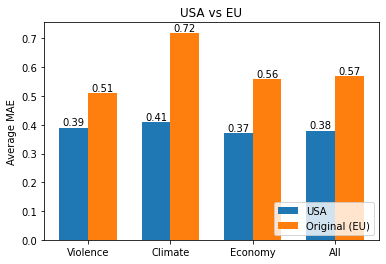

In [38]:
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(x)) - width/2, y, width, label='USA')
rects2 = ax.bar(np.arange(len(x)) + width/2, y_gt, width, label='Original (EU)')

ax.set_ylabel('Average MAE')
ax.set_title('USA vs EU')
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.legend(loc = "lower right")

ax.bar_label(rects1, padding=0)
ax.bar_label(rects2, padding=0)


plt.show()

Text(0.5, 0, 'Year')

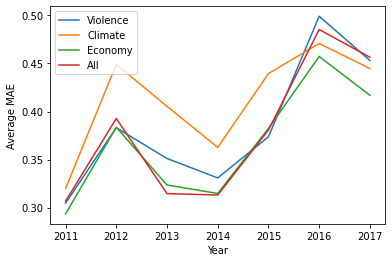

In [39]:
plt.plot(plot_slices,line_plot_mae["Violence"],label="Violence")
plt.plot(plot_slices,line_plot_mae["Climate"],label="Climate")
plt.plot(plot_slices,line_plot_mae["Economy"],label="Economy")
plt.plot(plot_slices,line_plot_mae["All"],label="All")
plt.legend(loc="upper left")
plt.ylabel('Average MAE')
plt.xlabel('Year')

Text(0.5, 0, 'Year')

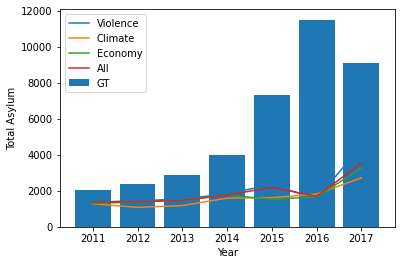

In [40]:
plt.plot(plot_slices,line_plot_absolute["Violence"],label="Violence")
plt.plot(plot_slices,line_plot_absolute["Climate"],label="Climate")
plt.plot(plot_slices,line_plot_absolute["Economy"],label="Economy")
plt.plot(plot_slices,line_plot_absolute["All"],label="All")
plt.bar(plot_slices,line_plot_gt["All"],label="GT")
plt.legend(loc="upper left")
plt.ylabel('Total Asylum')
plt.xlabel('Year')

In [41]:
line_plot_gt

{'Violence': [2037.020040198246,
  2368.5087093117686,
  2904.17777484336,
  3969.426853835245,
  7304.223242122217,
  11508.903098253912,
  9090.568287667722],
 'Climate': [2037.020040198246,
  2368.5087093117686,
  2904.17777484336,
  3969.426853835245,
  7304.223242122217,
  11508.903098253912,
  9090.568287667722],
 'Economy': [2037.020040198246,
  2368.5087093117686,
  2904.17777484336,
  3969.426853835245,
  7304.223242122217,
  11508.903098253912,
  9090.568287667722],
 'All': [2037.020040198246,
  2368.5087093117686,
  2904.17777484336,
  3969.426853835245,
  7304.223242122217,
  11508.903098253912,
  9090.568287667722]}